## The Data

At this link, you will find a dataset containing information about heart disease patients: https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1

A description of the original dataset can be found here: https://archive.ics.uci.edu/dataset/45/heart+disease (However, this dataset has been cleaned and reduced, and the people have been given fictious names.)

In [41]:
import pandas as pd
import numpy as np
from plotnine import *
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [62]:
df = pd.read_csv("https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1")
df.head()

,Name,age,sex,cp,trtbps,chol,restecg,thalach,diagnosis
0,Magnolia Cassin,60,1,1,117,230,1,160,No Disease
1,Dr. Cathern Heathcote,60,0,3,102,318,1,160,Disease
2,Miles Wolf,62,0,3,130,263,1,97,No Disease
3,Mikaila Block,43,1,1,115,303,1,181,Disease
4,Mrs. Jacquline Marquardt,66,1,1,120,302,0,151,Disease


In [63]:
mean_age = df["age"].mean()
mean_chol = df["chol"].mean()
std_age = df["age"].std()
std_chol = df["chol"].std()

df["age_std"] = (df["age"] - mean_age) / std_age
df["chol_std"] = (df["chol"] - mean_chol) / std_chol

df.head()

,Name,age,sex,cp,trtbps,chol,restecg,thalach,diagnosis,age_std,chol_std
0,Magnolia Cassin,60,1,1,117,230,1,160,No Disease,0.661295,-0.345593
1,Dr. Cathern Heathcote,60,0,3,102,318,1,160,Disease,0.661295,1.309270
2,Miles Wolf,62,0,3,130,263,1,97,No Disease,0.875090,0.274981
3,Mikaila Block,43,1,1,115,303,1,181,Disease,-1.155957,1.027191
4,Mrs. Jacquline Marquardt,66,1,1,120,302,0,151,Disease,1.302679,1.008386


## 1. Logistic Regression

Fit a Logistic Regression using only `age` and `chol` (cholesterol) as predictors.

In [46]:
X = df[['age', 'chol']]
y = df['diagnosis']

logistic_model = Pipeline([("standardize", StandardScaler()),
                           ("logistic", LogisticRegression())])

logistic_model_fitted = logistic_model.fit(X, y)

logistic_age_coef = logistic_model_fitted.named_steps['logistic'].coef_[0][0]
logistic_chol_coef = logistic_model_fitted.named_steps['logistic'].coef_[0][1]
logistic_intercept = logistic_model_fitted.named_steps['logistic'].intercept_

**For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?**

In [48]:
z_age = (55 - mean_age) / std_age
z_chol = (-logistic_intercept - logistic_age_coef * z_age) / logistic_chol_coef
chol_raw = z_chol * std_chol + mean_chol
chol_raw

array([368.08525191])

In [ ]:
# aligns with above graph
z_chol, z_age

If cutoff is 0.5, then a 55 year old would need to have atleast 368mg/dL cholesterol level to be categorized with present heart disease.

**How high for the doctors to estimate a 90% chance that heart disease is present?**

In [32]:
age_raw = 55
L = np.log(0.9 / (1 - 0.9))

z_age = (age_raw - mean_age) / std_age
z_chol_90 = (L - b_0 - b_age * z_age) / b_chol
chol_raw_90 = z_chol_90 * std_chol + mean_chol
chol_raw_90

array([1585.49048461])

## 2. Linear Discriminant Analysis

Fit an LDA model using only `age` and `chol` (cholesterol)  as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [49]:
lda_model = Pipeline([("standardize", StandardScaler()),
                      ("lda", LinearDiscriminantAnalysis())])

lda_model_fitted = lda_model.fit(X, y)

lda_age_coef = lda_model_fitted.named_steps['lda'].coef_[0][0]
lda_chol_coef = lda_model_fitted.named_steps['lda'].coef_[0][1]
lda_intercept = lda_model_fitted.named_steps['lda'].intercept_

lda_intercept, lda_chol_coef, lda_age_coef

(array([-0.26973565]),
 np.float64(0.09493491278066943),
 np.float64(0.4344658185163842))

In [51]:
z_age = (55 - mean_age) / std_age
z_chol = (-lda_intercept - lda_age_coef * z_age) / lda_chol_coef
chol_raw = z_chol * std_chol + mean_chol
chol_raw
# mg/dL should be greater than 368.6

array([368.60612891])

In [40]:
z_age, z_chol

(np.float64(0.1268094358001019), array([2.26093099]))

## 3. Support Vector Classifier

Fit an SVC model using only `age` and `chol` as predictors.  Don't forget to tune the regularization parameter.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [42]:
# tune hp
param_grid = {'svc__C': [0.01, 0.1, 1, 10, 100]}

svc_pipeline = Pipeline([("standardize", StandardScaler()),
                         ("svc", SVC(kernel="linear", probability=True))])

svc_pipeline_grid = GridSearchCV(svc_pipeline, param_grid, cv=5)
svc_pipeline_grid.fit(X, y)

svc_pipeline_best = svc_pipeline_grid.best_estimator_
svc_model_best = svc_pipeline_best.named_steps["svc"]

svc_model_best # best model has C=10

SVC(C=10, kernel='linear', probability=True)

In [44]:
svc_age_coef  = svc_model_best.coef_[0][0]
svc_chol_coef = svc_model_best.coef_[0][1]
svc_intercept = svc_model_best.intercept_[0]

(np.float64(-0.31134523984506396),
 np.float64(0.19360163718551782),
 np.float64(0.6009556681731714))

In [52]:
z_age = (55 - mean_age) / std_age
z_chol = (-svc_intercept - svc_age_coef * z_age) / svc_chol_coef
chol_raw = z_chol * std_chol + mean_chol
chol_raw
# mg/dL should be greater than 312.96

np.float64(312.96298888041383)

## 4. Comparing Decision Boundaries

Make a scatterplot of `age` and `chol`, coloring the points by their true disease outcome.  Add a line to the plot representing the **linear separator** (aka **decision boundary**) for each of the three models above.

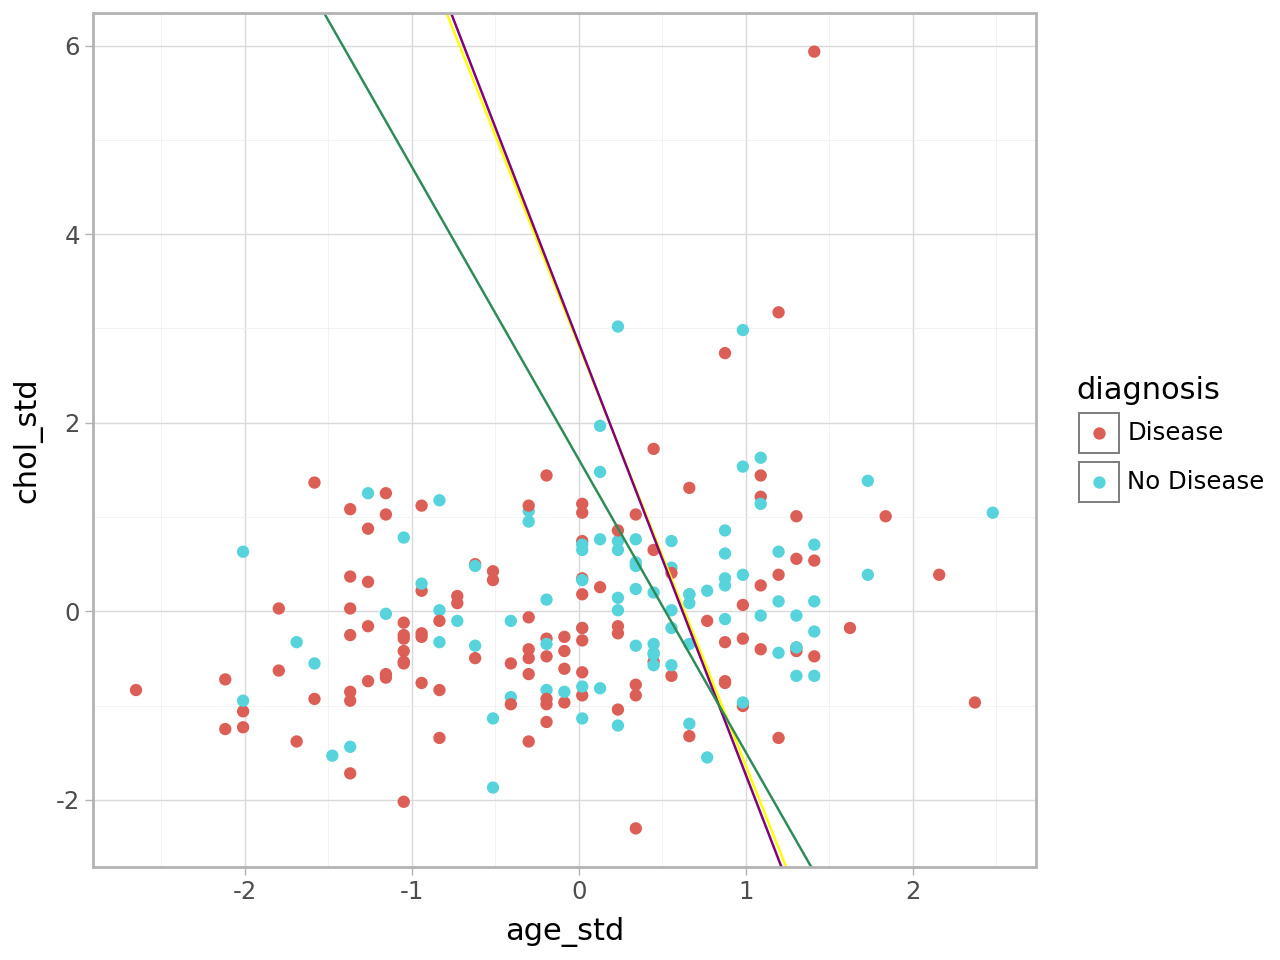

In [59]:
(ggplot(df, aes(x = "age_std", y = "chol_std", color = "diagnosis")) +
 geom_point() +
 geom_abline(intercept = - logistic_intercept / logistic_chol_coef, slope = - logistic_age_coef / logistic_chol_coef, color = "yellow") +
 geom_abline(intercept = - lda_intercept / lda_chol_coef, slope = - lda_age_coef / lda_chol_coef, color = "purple") +
 geom_abline(intercept = - svc_intercept / svc_chol_coef, slope = - svc_age_coef / svc_chol_coef, color = "seagreen") +
 theme_light())

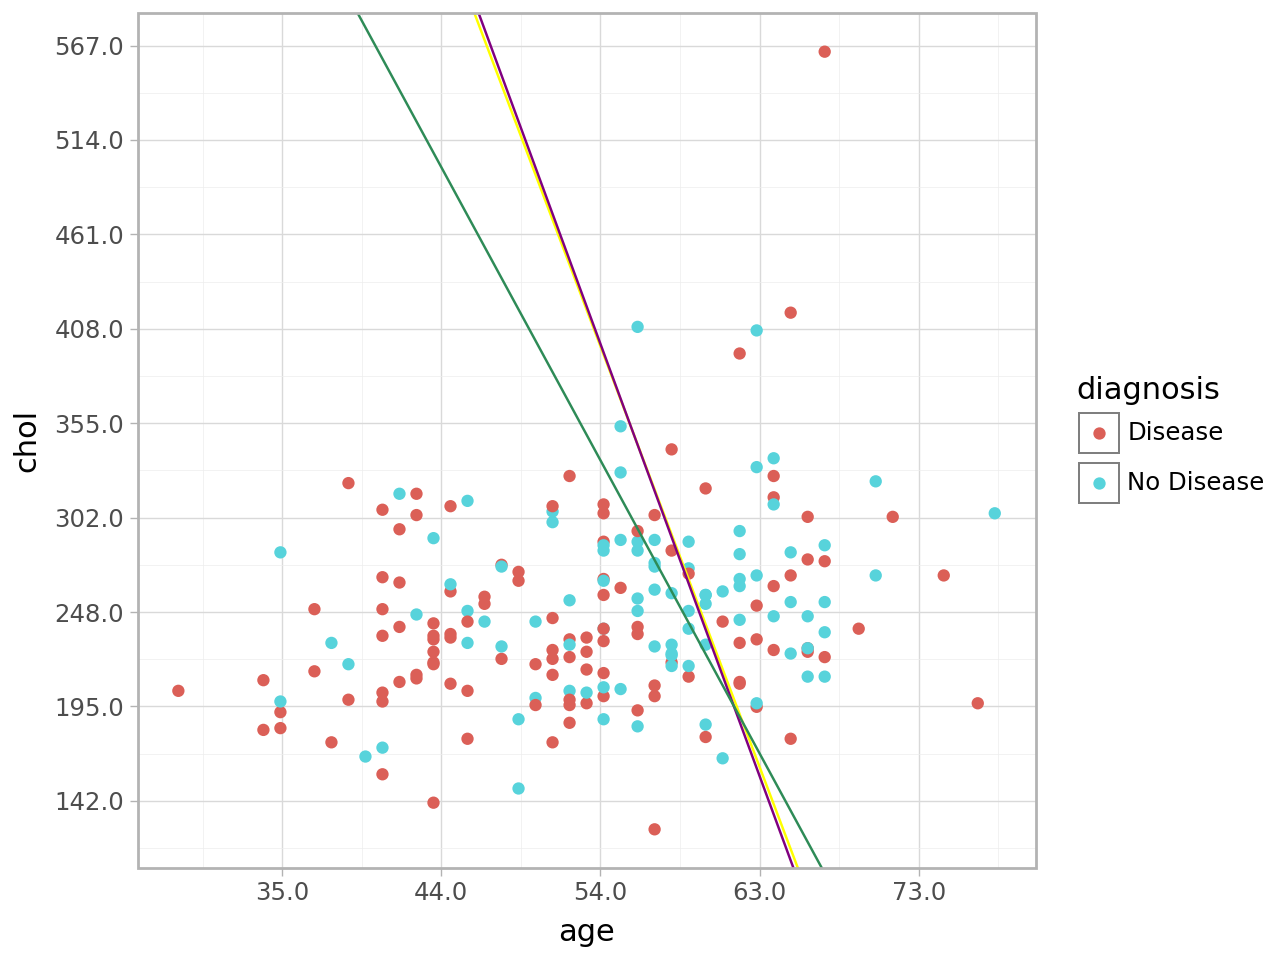

In [60]:
(ggplot(df, aes(x="age_std", y="chol_std", color="diagnosis")) +
 geom_point() +
 geom_abline(intercept = - logistic_intercept / logistic_chol_coef, slope = - logistic_age_coef / logistic_chol_coef, color = "yellow") +
 geom_abline(intercept = - lda_intercept / lda_chol_coef, slope = - lda_age_coef / lda_chol_coef, color = "purple") +
 geom_abline(intercept = - svc_intercept / svc_chol_coef, slope = - svc_age_coef / svc_chol_coef, color = "seagreen") +
 scale_x_continuous(breaks = np.arange(-2, 3), labels = np.round(mean_age + std_age * np.arange(-2, 3), 0)) +
 scale_y_continuous(breaks = np.arange(-2, 7), labels = np.round(mean_chol + std_chol * np.arange(-2, 7), 0)) +
 labs(x = "age", y = "chol") +
 theme_light())